In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import re
from scipy.signal import savgol_filter
from math import ceil, floor
from sklearn.linear_model import LogisticRegression
# from pymuller import muller

#### Comparison with Angie's method

In [2]:
# #GISAID Data
# metadata = pd.read_csv("../variant_data/metadata.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])
# metadata["alias"] = metadata["Virus name"].apply(lambda row: "/".join(row.split("/")[2:]))

# #NCBI data from curl command with complete_only=false and annotated_only=false
# all_ncbi = pd.read_csv("../variant_data/all_ncbi_covid_genomes.csv")
# # print(all_ncbi.shape)
# all_ncbi = all_ncbi.dropna(subset=["Isolate Name"])
# all_ncbi["alias"] = all_ncbi["Isolate Name"].apply(lambda row: row.split(",")[0].split(" isolate ")[-1])
# all_ncbi.alias = all_ncbi.alias.apply(lambda row: "/".join(row.split("/")[-2:]))

# #Angie's join data
# join_data = pd.read_table("../variant_data/epiToPublic.tsv", header=None, low_memory=True)
# join_data.columns = ["EPI", "Accession", "name", "date"]

# #Angie Overlap
# angie_epis = list(set(metadata["Accession ID"]) & set(join_data.EPI))
# angie_overlap = metadata[metadata["Accession ID"].isin(angie_epis)][["Accession ID", "alias", "Virus name", "Submission date"]]

# #My Overlap
# my_overlap = metadata[metadata.alias.isin(list(set(metadata.alias) & set(all_ncbi.alias)))][["Accession ID", "alias", "Virus name", "Submission date"]]
# my_overlap = my_overlap[my_overlap["Submission date"] <= angie_overlap["Submission date"].max()]

# #In mine but not hers
# only_in_mine = my_overlap[~my_overlap["Accession ID"].isin(angie_epis)]

# #In hers but not mine
# only_in_hers = angie_overlap[~angie_overlap["Accession ID"].isin(my_overlap["Accession ID"])]

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Setup

In [2]:
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

# join_data = pd.read_csv("../variant_data/epiToPublic_USA.tsv", sep="\t", header=None)
join_data = pd.read_table("../variant_data/epiToPublic.tsv", header=None, low_memory=True)
join_data.columns = ["EPI", "Accession", "name", "date"]

accession_to_epi = join_data.set_index("Accession")["EPI"].to_dict()
gis_accessions = join_data.Accession.tolist()

def convert_state_stfips(state):
    try:
        return state_to_stfips[state]
    except:
        return np.nan
    
def convert_abbr_stfips(abbr):
    try:
        return abbr_to_stfips[abbr]
    except:
        return np.nan
        
def convert_accession_epi(accession):
    try:
        return accession_to_epi[accession]
    except:
        return np.nan

In [38]:
metadata = pd.read_csv("../variant_data/metadata.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])
# print(metadata.columns)
# metadata = metadata[["Accession ID", \
#                    "Collection date", \
#                    "Submission date", \
#                    "Location", \
#                    "Additional location information", \
#                    "Sequence length", \
#                    "Host", \
#                    "AA Substitutions", \
#                    "Is reference?", \
#                    "Pango lineage"]]
def get_nth_slash(row, n):
    try:
        return row.split("/")[n].strip()
    except:
        return np.nan
    
for i in range(4):
    metadata[f"Location_{i}"] = metadata["Location"].apply(lambda row: get_nth_slash(row, i))
metadata = metadata.rename(columns={"Location_1":"country", "Location_2":"state"})
metadata = metadata[metadata["country"] == "USA"]
metadata["alias"] = metadata["Virus name"].apply(lambda row: "/".join(row.split("/")[2:]))
# metdata = metadata.rename(columns={"Accession ID":"EPI"})

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<AxesSubplot:>

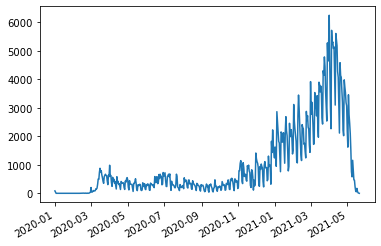

In [39]:
metadata["Collection date"].value_counts().plot()

In [40]:
ncbi = pd.read_csv("../variant_data/sequences.csv", parse_dates=["Release_Date"])
ncbi["is_USA"] = ncbi["Geo_Location"].apply(lambda row: True if "USA" in str(row) else False)
ncbi = ncbi[ncbi.is_USA]
all_usa_ncbi = ncbi.shape
print(ncbi.shape[0], "NCBI from the US")

ncbi = ncbi.dropna(subset=["GenBank_Title"])
ncbi["alias"] = ncbi["GenBank_Title"].apply(lambda row: row.split(",")[0].split(" isolate ")[-1].split("USA/")[-1])

accession_to_epi = join_data.set_index("Accession")["EPI"].to_dict()
ncbi["EPI"] = ncbi.Accession.apply(convert_accession_epi)

160116 NCBI from the US


In [14]:
t = ncbi.alias.value_counts()
t[t>1].sum()

2439

In [46]:
ncbi = ncbi[(~ncbi.EPI.isin(metadata["Accession ID"])) & (~ncbi.alias.isin(metadata.alias))] # #.shape
# ncbi[~ncbi.alias.isin(metadata.alias)]
only_ncbi = ncbi.shape
ncbi = ncbi[~ncbi.USA.isna()][["Collection_Date", "Pangolin", "USA", "Release_Date"]]
ncbi.columns = ["date", "variant", "state", "submission_date"]
ncbi.date = pd.to_datetime(ncbi.date)
ncbi.state = ncbi.state.apply(convert_abbr_stfips)
ncbi = ncbi.dropna()
print(all_usa_ncbi[0] - only_ncbi[0], "in NCBI and GISAID")
print(only_ncbi[0], "in NCBI only")

metadata = metadata[["Collection date", "Pango lineage", "state", "Submission date"]]
metadata.columns = ["date", "variant", "state", "submission_date"]
metadata.date = pd.to_datetime(metadata.date)
metadata.state = metadata.state.apply(convert_state_stfips)
metadata = metadata.dropna()

153584 in NCBI and GISAID
6532 in NCBI only


In [18]:
def get_state_variants(state, rolling=False, normalize=True):
    
    variant_names = variants.variant.unique()
    
    if state in ["US", "USA"]:
        data = variants.copy()
    else:    
        data = variants[variants.state == state].sort_values("date")
    data = data.groupby(["date", "variant"]).count().reset_index()
    data = data.pivot(index="date", columns="variant", values="state").fillna(0)
    samples = data.sum(axis=1)
#     data = data.iloc[:-10] #Take out noisy last 10 days
    if rolling:
#         data = data.resample("7D").sum().copy()
        data = data.rolling(7).mean()
    else:  
        data = data.apply(lambda col: savgol_filter(col, 31, 1), axis=0)
        
#         data = data.rolling(7).mean()
#     else:
#         data = data.resample("14D").sum()
    data = data.where(data > 0, other=0)
    data.other = data.other.replace(0, 0.001)
    if normalize:
        data = data.divide(data.sum(axis=1), axis=0)
    for column in set(variant_names) - set(data.columns):
        data[column] = 0
    data["samples"] = samples
    data["days"] = data.index
    data.days = (data.days - data.index.min()).dt.days
    return data

In [19]:
def train_state_prevalence_model(data):
    
    long_data = data.melt(id_vars=["days", "samples"])
    long_data.samples = long_data.samples * 100 #So small numbers are still considered
    long_data.samples = long_data.samples * long_data.value
    # long_data.samples = long_data.samples.apply(lambda row: ceil(max(1, row)))
#     long_data.samples = long_data.samples.apply(lambda row: ceil(row)).replace(0, np.nan)
    long_data.samples = long_data.samples.apply(lambda row: floor(row)).replace(0, np.nan)
    long_data = long_data.dropna().sort_values("days").drop(columns=["value"])
    
    model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=5000, random_state=42)
    model.fit(long_data.days.to_numpy().reshape(-1,1), long_data.variant, sample_weight=long_data.samples)
    return model

def predict_variants(state, num_days_out=60):
    
    data = get_state_variants(state)
    variant_names = [c for c in data.columns if c not in ["samples", "days"]]
    
    model = train_state_prevalence_model(data)
    num_days = (data.index.max() - data.index.min()).days + num_days_out
    
    x_pred = np.array(range(0, num_days)).reshape(-1,1)
    preds = model.predict_proba(x_pred)
    preds = pd.DataFrame(preds, columns=model.classes_)
    preds.index = pd.Series(preds.index).apply(lambda row: data.index.min() + np.timedelta64(row, "D"))
    for column in set(variant_names) - set(preds.columns):
        preds[column] = 0
    preds = preds[sorted(preds.columns)]
        
    return preds

def plot_variant_predictions(state, ax, num_days_out=60, stackplot=True):
    
    variants = predict_variants(state, num_days_out=num_days_out)
    last_gt = (variants.index.max() - np.timedelta64(num_days_out, "D"))
    past_variants = variants.loc[:last_gt]
    future_variants = variants.loc[last_gt + np.timedelta64(1, "D"):]
    if stackplot:
        ax.set_prop_cycle(color=terrain_variant_colors)
#         ax.stackplot(variants.index, variants.T, labels=variants.columns)
        ax.stackplot(past_variants.index, past_variants.T, labels=past_variants.columns)
        ax.stackplot(future_variants.index, future_variants.T, labels=[], alpha=0.5)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="upper left")
        lines = handles
    else:
        ax.set_prop_cycle(color=tab_variant_colors)
        lines = ax.plot(past_variants.index, past_variants, linewidth=4)
        ax.plot(future_variants.index, future_variants, linewidth=4)
        ax.legend(lines[::-1], past_variants.columns[::-1], loc="upper left")
        
    ax.axvline(variants.index.max() - np.timedelta64(num_days_out, "D"), color="k", linestyle="--", linewidth=2)
    ax.set_ylim(0,1)
    ax.set_xlim(variants.index.min(), variants.index.max())
    return lines, past_variants.columns

In [15]:
def plot_state_variants(state, ax, rolling=False, normalize=True, stackplot=True):
    
    
    data = get_state_variants(state, rolling=rolling, normalize=normalize)
    data = data.drop(columns=["samples", "days"])
    
    data = data[sorted(variant_names)] #.abs()
    if stackplot:
        ax.set_prop_cycle(color=terrain_variant_colors)
        ax.stackplot(data.index, data.T, labels=data.columns)
    else:
        ax.set_prop_cycle(color=tab_variant_colors)
        data.plot(ax=ax, linewidth=4)
        
    ax.legend(loc="upper left")   
    
#     lines = ax.plot(past_variants.index, past_variants, linewidth=4)
#     ax.plot(future_variants.index, future_variants, linewidth=4)
#     ax.legend(lines[::-1], past_variants.columns[::-1], loc="upper left")
        
#     ax.axvline(variants.index.max() - np.timedelta64(num_days_out, "D"), color="k", linestyle="--", linewidth=2)
#     ax.set_ylim(0,1)
#     ax.set_xlim(variants.index.min(), variants.index.max())
# #     return data

In [133]:
combine_lineages = False
combined_str = "_with_sub_lineages_combined" if combine_lineages else ""

variants = pd.concat([metadata, ncbi], ignore_index=True)
variants.date = pd.to_datetime(variants.date)
variants.submission_date = pd.to_datetime(variants.submission_date.apply(lambda row: str(row).split()[0]))

variants.to_csv(f"/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state{combined_str}.csv", index=False)

variants = variants[variants.date >= "2020-02-27"] #First day with >10 samples
vocs = ['B.1.1.7',
        'B.1.351',
        'P.1',
        'B.1.617.1',
        'B.1.617.2',
        'B.1.427',
        'B.1.429',
        'B.1.526',
        'B.1.526.1',
        'B.1.526.2']
variants.variant = variants.variant.apply(lambda row: row if row in vocs else "other")

if combine_lineages:
    variants.variant = variants.variant.apply(lambda row: re.sub(".[12]$", "", row))
variants.variant.unique()

variant_names = variants.variant.unique()
NUM_COLORS = len(variant_names)

cm = plt.get_cmap('terrain')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
terrain_variant_colors = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

### VDH Power Calculations

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='date'>

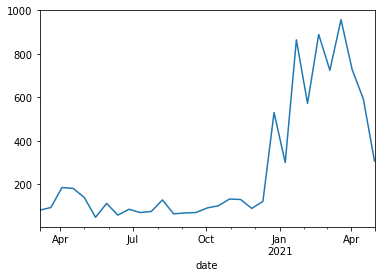

In [118]:
va_variants = variants[variants.state == "51"]
va_variants["count"] = 1
va_variants = va_variants.pivot_table(index="date", columns="variant", values="count", aggfunc=sum)
va_variants = va_variants.resample("14D").sum().replace(0, np.nan)
va_variant_first_seen = va_variants.idxmin().reset_index().to_numpy()
va_variant_props = va_variants.apply(lambda col: col / va_variants.sum(axis=1), axis=0)
# va_variants = va_variants.fillna(0)
samples = va_variants.sum(axis=1)
samples.plot() #resample('14D').sum().plot()

In [119]:
variant_info = []
for variant in va_variant_first_seen:
    variant, date = variant
    prev = va_variant_props[variant].loc[date]
    variant_info.append((variant, date, prev))

In [120]:
variant_info

[('B.1.1.7', Timestamp('2021-01-08 00:00:00'), 0.0033333333333333335),
 ('B.1.351', Timestamp('2021-01-22 00:00:00'), 0.003472222222222222),
 ('B.1.427', Timestamp('2020-12-11 00:00:00'), 0.008264462809917356),
 ('B.1.429', Timestamp('2021-04-16 00:00:00'), 0.0016891891891891893),
 ('B.1.526', Timestamp('2021-01-22 00:00:00'), 0.0011574074074074073),
 ('B.1.526.1', Timestamp('2020-12-25 00:00:00'), 0.0018867924528301887),
 ('B.1.526.2', Timestamp('2021-02-19 00:00:00'), 0.0011248593925759281),
 ('B.1.617.1', Timestamp('2021-04-02 00:00:00'), 0.002751031636863824),
 ('B.1.617.2', Timestamp('2021-03-19 00:00:00'), 0.0010449320794148381),
 ('P.1', Timestamp('2021-02-19 00:00:00'), 0.0011248593925759281),
 ('other', Timestamp('2021-04-30 00:00:00'), 0.07166123778501629)]

In [86]:
tab_variant_colors

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686, 1.0),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098, 1.0),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177, 1.0),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804, 1.0),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353, 1.0),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059, 1.0),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804, 1.0),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059, 1.0),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549, 1.0),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275, 1.0),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353, 1.0)]

[]

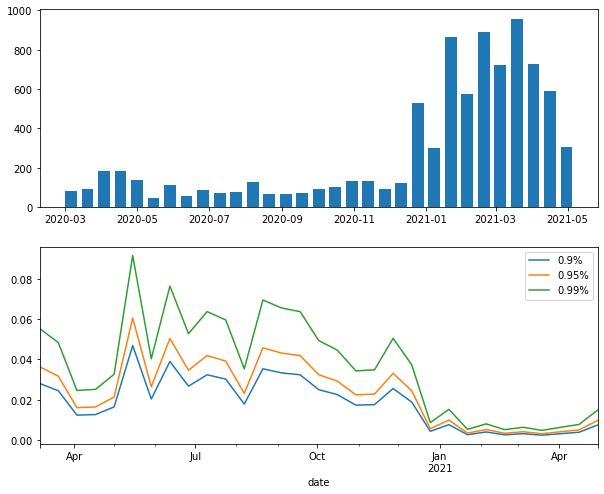

In [112]:
def apply_confidence_bound(col, prob):
    return 1 - (1 - prob)**(1/col)
sample_bounds = pd.DataFrame(samples, columns=["samples"])
for confidence in [0.9, 0.95, 0.99]:
    sample_bounds[f"{confidence}%"] = apply_confidence_bound(sample_bounds.samples, confidence)
fig, axs = plt.subplots(2, figsize=(10,8))
# sample_bounds["samples"].plot(ax=axs[0])
axs[0].bar(sample_bounds.index, sample_bounds.samples, width=10)
# twinx=ax.twinx()
sample_bounds.drop(columns=["samples"]).plot(ax=axs[1])
axs[1].plot()

### Variant Prevalence and Multinomial Fit plots

<AxesSubplot:xlabel='date'>

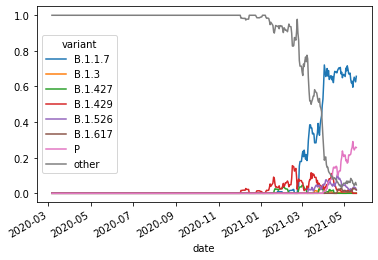

In [12]:
get_state_variants("20", rolling=True).drop(columns=["samples", "days"]).plot()

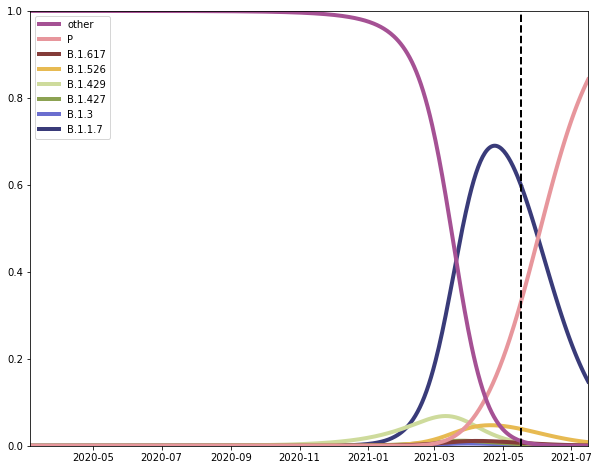

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
h1, l1 = plot_variant_predictions("20", ax, stackplot=False)

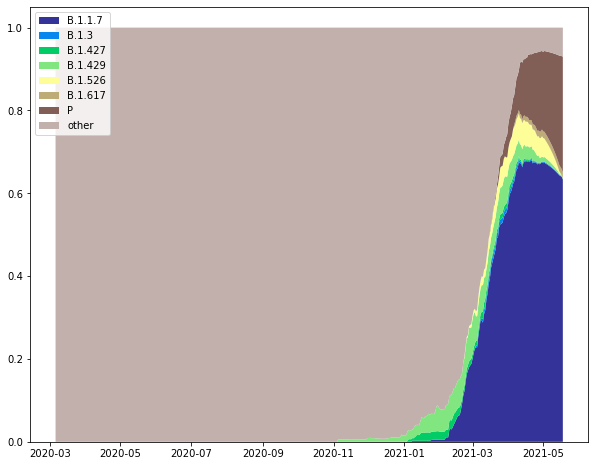

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
plot_state_variants("20", ax)

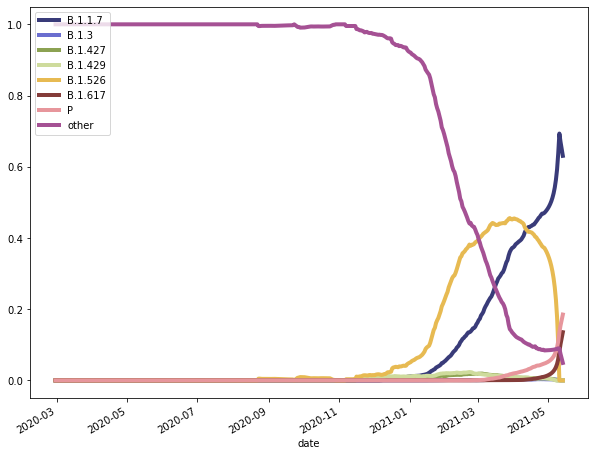

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
plot_state_variants("36", ax, stackplot=False)

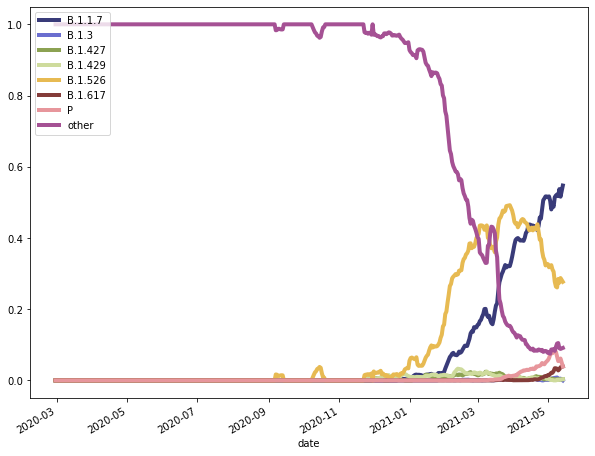

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
plot_state_variants("36", ax, rolling=True, stackplot=False)

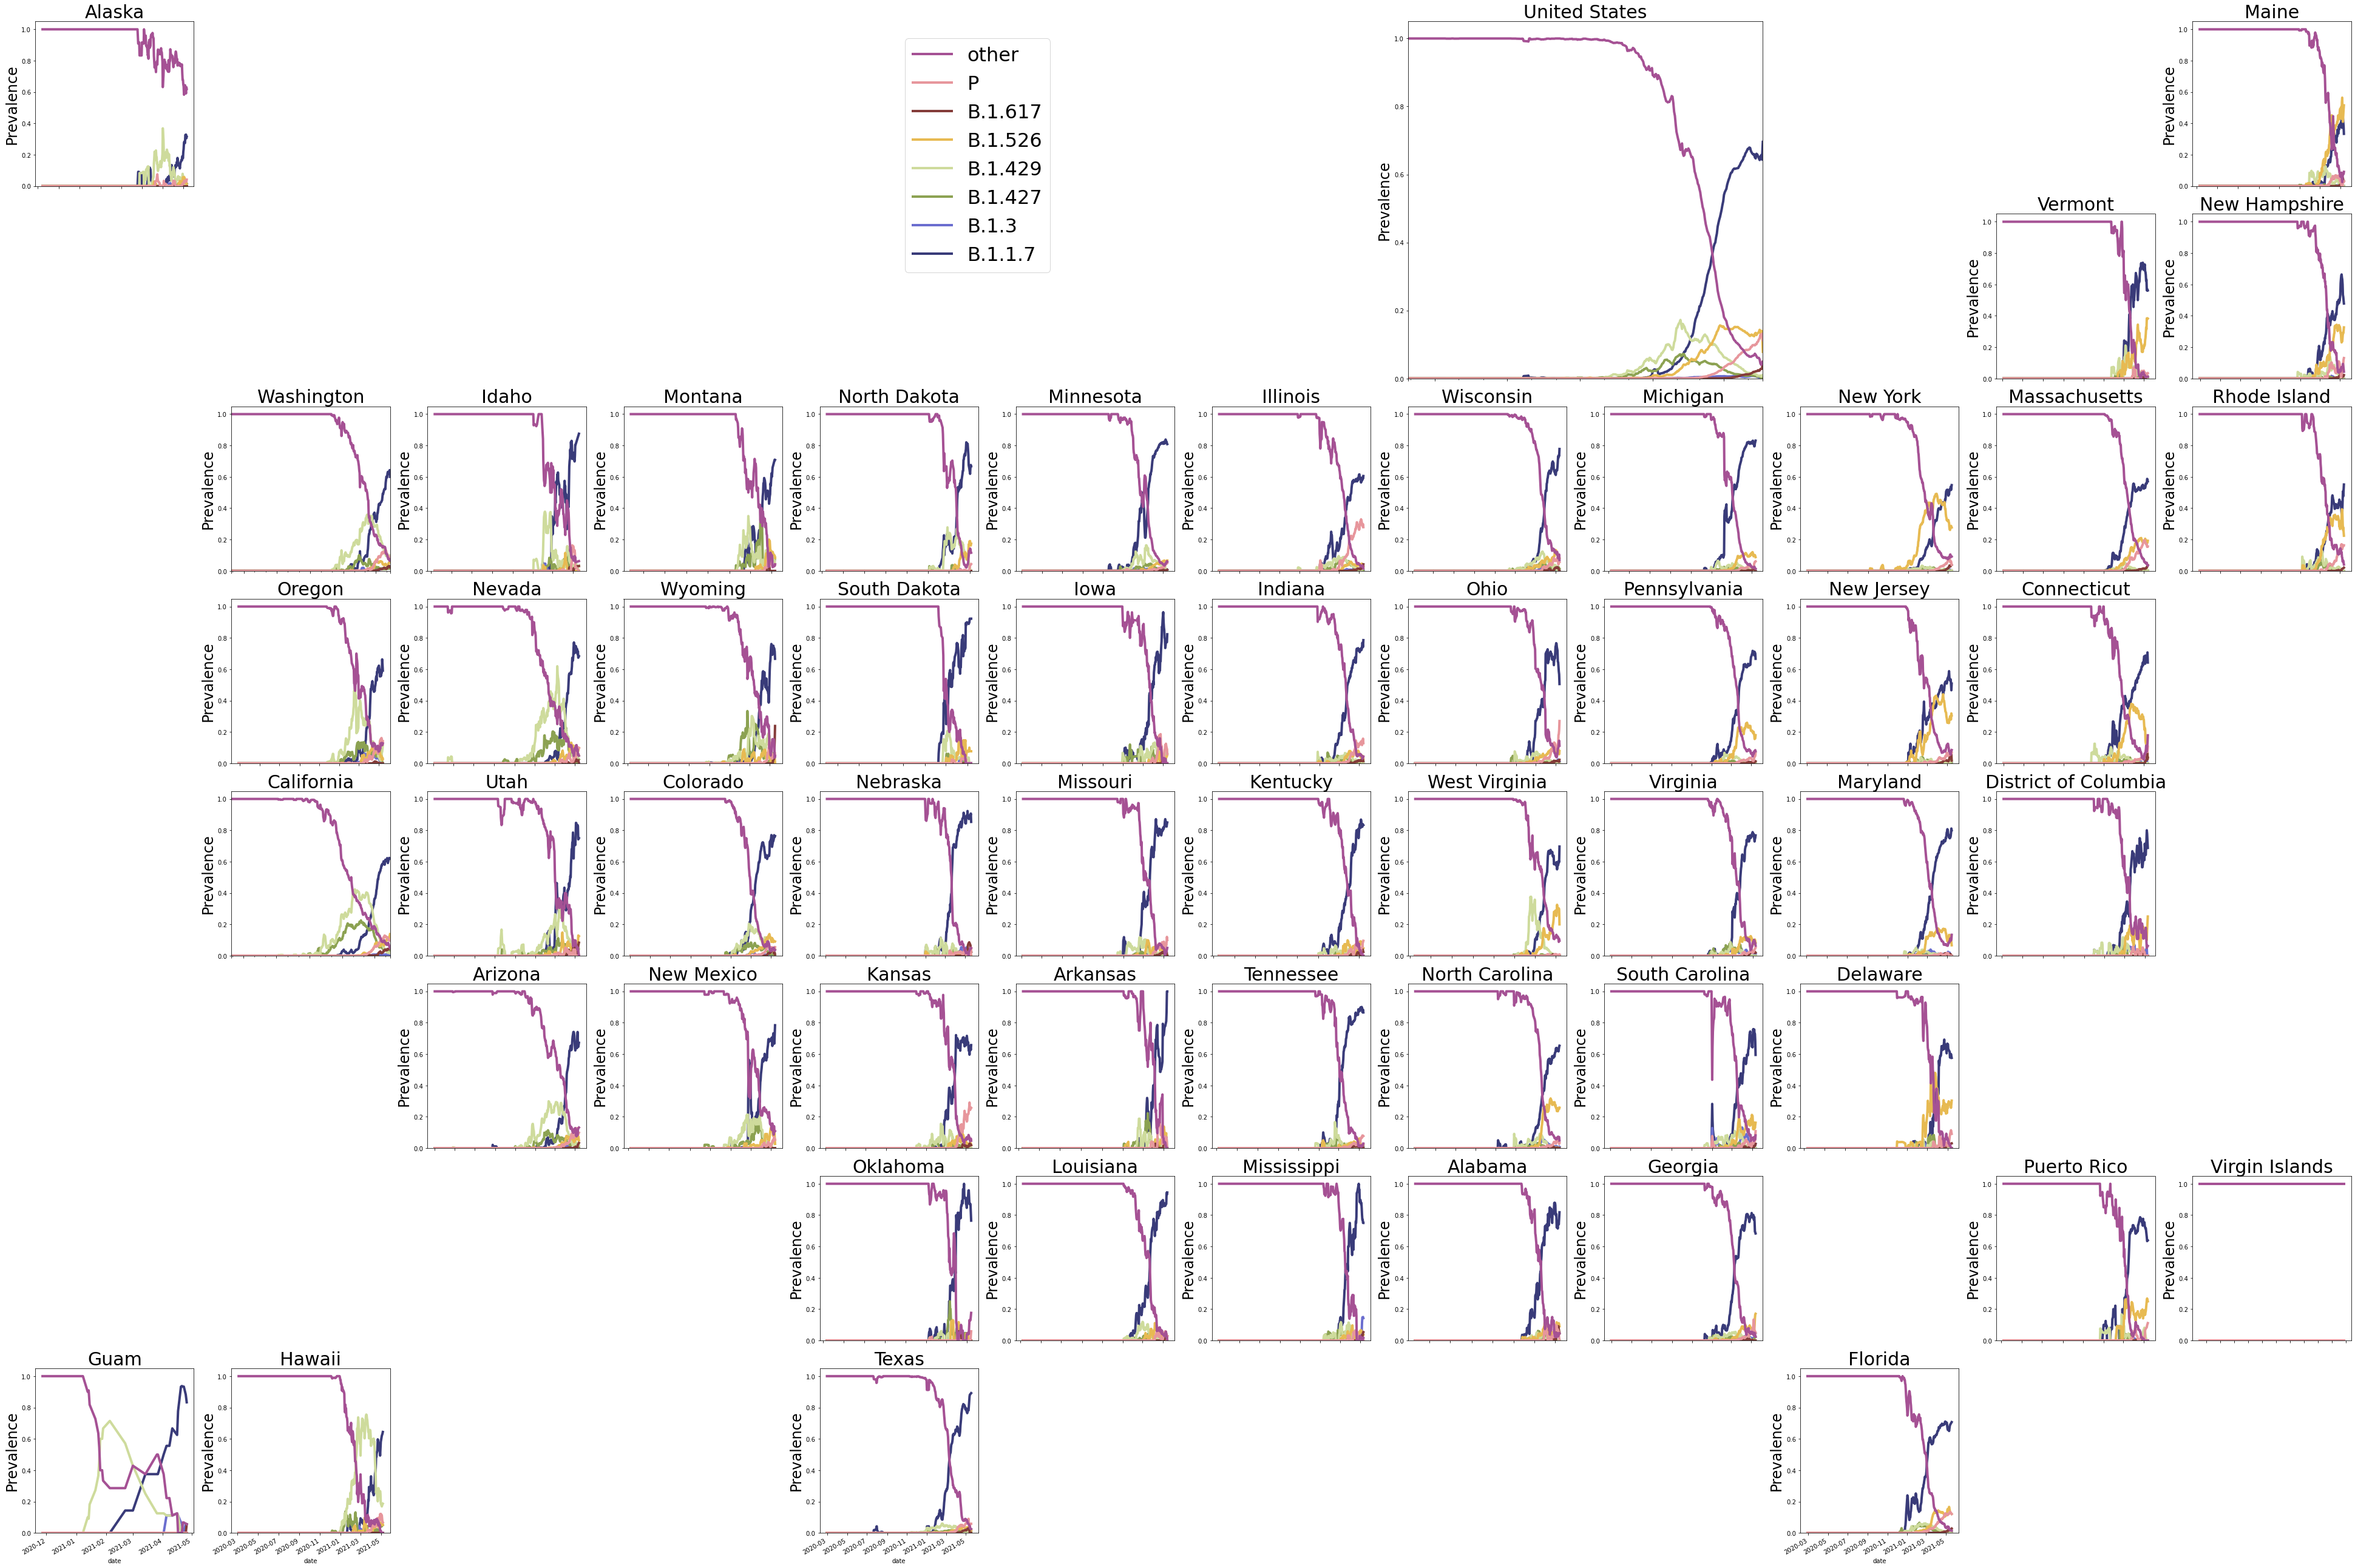

In [25]:
def get_us_grid():
    stat_notes = "/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/notebooks/"
    state_hhs = pd.read_csv(stat_notes+'../misc_data/state_hhs_map.csv',usecols=[0,1,2,3],names=['sFIPS','HHS','state','StateName'],dtype=str)
    state_hhs['HHS'] = state_hhs.HHS.apply(lambda x: 'HHS Region {}'.format(x))
    us_df = pd.read_csv(stat_notes+'../misc_data/us_subplot_grid.csv')
    
    return us_df

stackplot=False
rolling=True
rolling_str = "rolling" if rolling else "savgol"
stackplot_str = "stackplot" if stackplot else "lines"
stackplot_str = rolling_str + "_" + stackplot_str


us_df = get_us_grid()
fig = plt.figure(figsize=(54,36)) 
gs = fig.add_gridspec(8,12)

us_ax = fig.add_subplot(gs[0:2, 7:9])
plot_state_variants("US", us_ax, stackplot=stackplot, rolling=rolling)
# state_dfs["US"].plot(ax=us_ax, legend=False)
# state_variant_prevalence.mean(axis=1).loc["2021-01-01":"2021-05-10"].plot(ax=us_ax, color="k", linestyle="--", alpha=0.6)    
us_ax.set_title("United States", fontsize=30)
us_ax.set_ylabel("Prevalence", fontsize=24)
us_ax.set_ylim(0,1.05)
us_ax.get_legend().remove()

for r in range(8):
    for c in range(12):
        mask = (us_df.Row==r)&(us_df.Column==c)

        if len(us_df[mask])==0: # and not unseen_regions:
            pass
        else:
            ax = fig.add_subplot(gs[r,c])
            state = us_df[mask]['Name'].values[0]
            fips = state_to_stfips[state]
            
#             state_variant_prevalence[state_to_stfips[state]].loc["2021-01-01":"2021-05-10"].plot(ax=ax, color="k", linestyle="--", alpha=0.6, label="B117 Adaptive Prevalence")
#             abbr = state_to_state_abbr[state]
            try:
                plot_state_variants(fips, ax, stackplot=stackplot, rolling=rolling)
            except:
                ax.set_visible(False)
                continue
            ax.set_title(state, fontsize=30)
            ax.set_ylabel("Prevalence", fontsize=24)
            ax.set_ylim(0,1.05)
            h1, l1 = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        
fig.autofmt_xdate()
fig.legend(h1[::-1], l1[::-1], bbox_to_anchor=(0.45, 0.98), fontsize=32)
plt.tight_layout()
plt.savefig(f"output/voc_prevalence_proportions_ground_truth_{stackplot_str}_substrains_combined.png", dpi=100, bbox_inches="tight", facecolor="white")

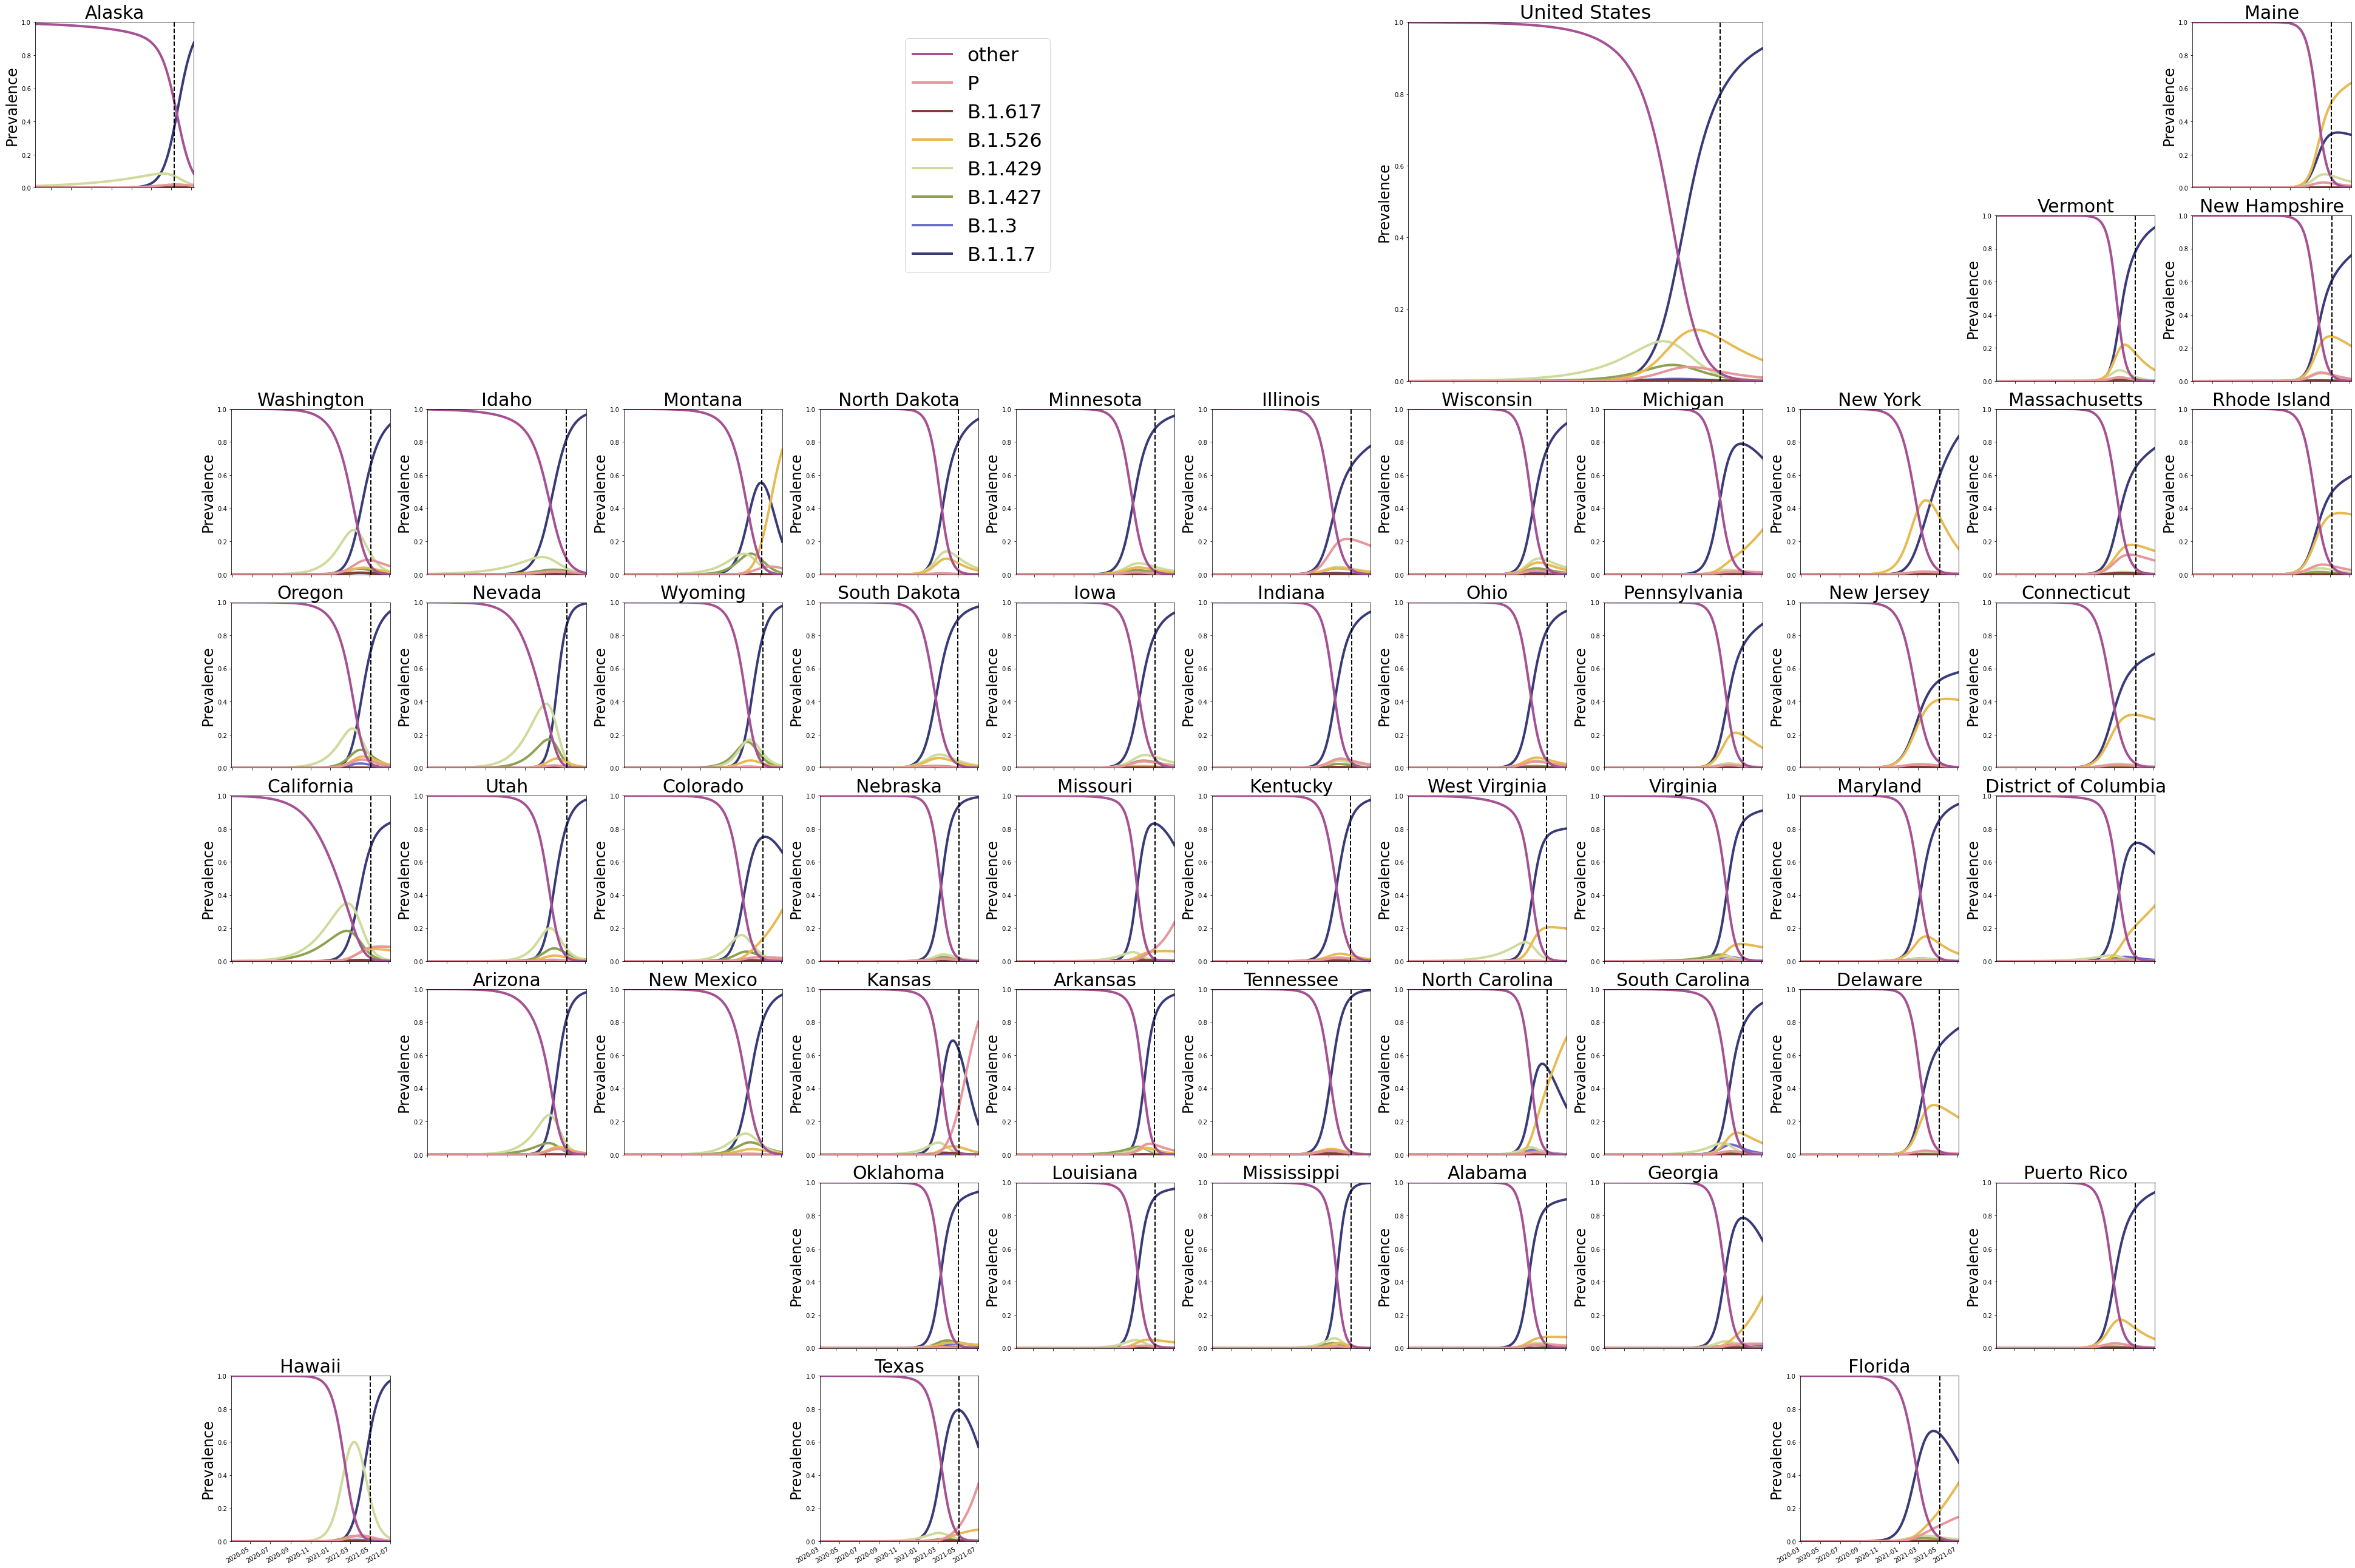

In [403]:
def get_us_grid():
    stat_notes = "/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/notebooks/"
    state_hhs = pd.read_csv(stat_notes+'../misc_data/state_hhs_map.csv',usecols=[0,1,2,3],names=['sFIPS','HHS','state','StateName'],dtype=str)
    state_hhs['HHS'] = state_hhs.HHS.apply(lambda x: 'HHS Region {}'.format(x))
    us_df = pd.read_csv(stat_notes+'../misc_data/us_subplot_grid.csv')
    
    return us_df

stackplot=False
stackplot_str = "stackplot" if stackplot else "lines"

us_df = get_us_grid()
fig = plt.figure(figsize=(54,36)) 
gs = fig.add_gridspec(8,12)

us_ax = fig.add_subplot(gs[0:2, 7:9])
plot_variant_predictions("US", us_ax, stackplot=stackplot)
us_ax.set_title("United States", fontsize=32)
us_ax.set_ylabel("Prevalence", fontsize=24)
us_ax.get_legend().remove()

for r in range(8):
    for c in range(12):
        mask = (us_df.Row==r)&(us_df.Column==c)

        if len(us_df[mask])==0: # and not unseen_regions:
            pass
        else:
            ax = fig.add_subplot(gs[r,c])
            state = us_df[mask]['Name'].values[0]
            fips = state_to_stfips[state]
            try:
                h1, l1 = plot_variant_predictions(fips, ax, stackplot=stackplot)
            except:
                ax.set_visible(False)
                continue
            ax.set_title(state, fontsize=30)
            ax.set_ylabel("Prevalence", fontsize=24)
#             h1, l1 = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        
#         break
#     break
    
        
fig.autofmt_xdate()
fig.legend(h1[::-1], l1[::-1], bbox_to_anchor=(0.45, 0.98), fontsize=32)
plt.tight_layout()
plt.savefig(f"output/voc_prevalence_proportions_predictions_{stackplot_str}_substrains_combined.png", dpi=100, bbox_inches="tight", facecolor="white")

In [ ]:
# test = predict_variants("36")
# test = (test * 10000).applymap(floor)
# test = test.reset_index(drop=True).reset_index()
# test = test.melt(id_vars=["index"])
# test.columns = ["Generation", "Identity", "Population"]
# name_to_ix = {strain:ix for ix, strain in enumerate(sorted(test.Identity.unique())[::-1])}
# test.Identity = test.Identity.apply(lambda row: name_to_ix[row])

# adjacency = [(0, ix) for ix in range(1,len(test.Identity.unique()))]
# adjacency = pd.DataFrame.from_records(adjacency, columns = ["Parent", "Identity"])
